# GluonTS - Transfer Learning Approach (quarterly) 

- Two datasets: A and B
- Dataset A: Dataset subsetted by frequency, i.e. `m4_quarterly_atm`
- Dataset B: Dataset subsetted by frequency and by domain, i.e. `m4_quarterly_industry`
- Network A: Trained on dataset A
- Network B: Trained on dataset B
- Both networks are evaluated on dataset B. 

- Adjust epochs to account for different size of the datasets

Goal: Check TZ1: "Does the network learn from time series of the same domain or is it helpful to use time series from other domains?"

- Both networks are trained for ten trials (deepar) or three trials (deepstate)

Note that there are already results where a network is trained on `m4_frequency_domain` and evaluated on the same network.

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports



In [3]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [4]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [6]:
dataset = get_dataset("m4_weekly", regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


### mv the data

Before moving on: Move the respective data according the required folder structure. In AWS:

- `mv [dataname] ../../.mxnet/gluon-ts/datasets/`

## Check the data

In [7]:
dataname_a = "m4_quarterly_atm"
dataset_a = get_dataset(dataname_a, regenerate=False)
len(dataset_a.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_atm.


24000

In [8]:
dataname_b1 = "m4_quarterly_macro"
dataset_b1 = get_dataset(dataname_b1, regenerate=False)
len(dataset_b1.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_macro.


5315

In [9]:
dataname_b2 = "m4_quarterly_micro"
dataset_b2 = get_dataset(dataname_b2, regenerate=False)
len(dataset_b2.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_micro.


6020

In [10]:
dataname_b3 = "m4_quarterly_other"
dataset_b3 = get_dataset(dataname_b3, regenerate=False)
len(dataset_b3.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_other.


865

In [11]:
dataname_b4 = "m4_quarterly_finance"
dataset_b4 = get_dataset(dataname_b4, regenerate=False)
len(dataset_b4.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_finance.


5305

In [12]:
dataname_b5 = "m4_quarterly_industry"
dataset_b5 = get_dataset(dataname_b5, regenerate=False)
len(dataset_b5.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_industry.


4637

In [13]:
dataname_b6 = "m4_quarterly_demographic"
dataset_b6 = get_dataset(dataname_b6, regenerate=False)
len(dataset_b6.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.


1858

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 24000
length test: 24000

start:
 1750-01-31 00:00:00
target:
 [7407.412  7528.566  7374.709  7395.5146 7654.008  7686.8477 7578.191
 7904.3765 7744.0493 7889.909 ]
feat_static_cat:
 [1]


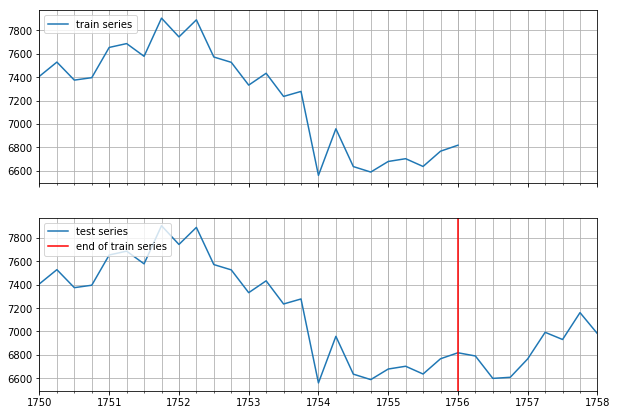

In [14]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset B

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 5315
length test: 5315

start:
 1750-01-31 00:00:00
target:
 [7407.412  7528.566  7374.709  7395.5146 7654.008  7686.8477 7578.191
 7904.3765 7744.0493 7889.909 ]
feat_static_cat:
 [1]


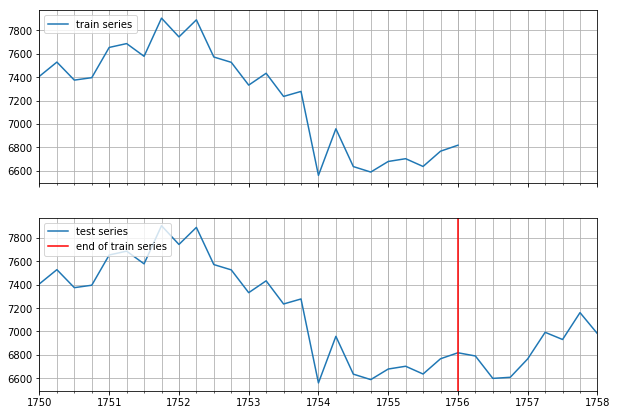

In [15]:
dataset_b = dataset_b1

train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [16]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: False
Length test test: False
Frequency test: True


## Modeling: DeepAR

In [17]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [18]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=MetaData(freq='3M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='24000')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=8), train=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf749b0>, test=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf28588>)

 TrainDatasets(metadata=MetaData(freq='3M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='5315')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=8), train=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf28ac8>, test=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf28978>)


In [19]:
print(dataname_a)
print(dataname_b1)

m4_quarterly_atm
m4_quarterly_macro


In [20]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
#     assert ( len(dataset_a.train)==len(dataset_b.train) )
#     assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )
    
#     estimator = DeepAREstimator(
#         trainer=trainer,
#         cardinality= [
#             feat_static_cat.cardinality 
#             for feat_static_cat in dataset_a.metadata.feat_static_cat
#         ],
#         context_length=dataset_a.metadata.prediction_length,
#         prediction_length=dataset_a.metadata.prediction_length,
#         freq=dataset_a.metadata.freq,
#         use_feat_static_cat=True
#     )
    
    # predictor trained on dataset_a, evaluated on dataset_b
    predictor_a=estimator.train(training_data=dataset_a.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_b.test, predictor=predictor_a, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_b.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_a
    output["eval data"]=dataname_b
    
    df=pd.DataFrame([output])

    return df

    

## Subsets

In [21]:
print(dataname_a)
print(dataname_b1)

m4_quarterly_atm
m4_quarterly_macro


## Study 1: `m4_quarterly_atm` vs. `m4_quarterly_macro` trained network

- Alternating between Run I - 10 trials A:B vs. 
- Run II - 10 trials of B:B


In [1]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_macro", dataname_b="m4_quarterly_macro", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

## Study 2: `m4_quarterly_atm` vs. `m4_quarterly_micro` trained network

- Alternating between A:B and B:B

In [2]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_micro", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

## Study 3: `m4_quarterly_atm` vs `m4_quarterly_other`

- Alternating between A:B and B:B

In [ ]:
# results = pd.DataFrame()

# for i in range(42,45):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_other", dataname_b="m4_quarterly_other", seed=i, epochs=400, num_batches=200)
#     pprint(df)
#     results = results.append(df)
    
# results

## Study 4: `m4_quarterly_atm` vs `m4_quarterly_finance`

In [ ]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_finance", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

In [ ]:
results = pd.DataFrame()

for i in range(52,62):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_finance", dataname_b="m4_quarterly_finance", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(45,47):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_finance", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(45,47):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_finance", dataname_b="m4_quarterly_finance", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

## Study 5: `m4_quarterly_atm` vs. `m4_quarterly_industry`

In [ ]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_industry", dataname_b="m4_quarterly_industry", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

In [31]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_industry", dataname_b="m4_quarterly_industry", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_industry.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 100/100 [00:01<00:00, 70.36it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[0] Elapsed time 1.423 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.914683
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.96it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[1] Elapsed time 1.391 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.432396
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.76it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[2] Elapsed time 1.395 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.412414
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.58it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 1.379 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.212453
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.07it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[4] Elapsed time 1.429 seconds
INFO:root:E

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.05it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[74] Elapsed time 1.409 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.714274
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.61it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[75] Elapsed time 1.459 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.795312
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.66it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[76] Elapsed time 1.417 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.827966
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.14it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 1.388 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.732759
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.682716
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.30it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[110] Elapsed time 1.424 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.779538
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.54it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[111] Elapsed time 1.419 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.775925
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.63it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[112] Elapsed time 1.378 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.727176
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.77it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[113] Elapsed time 1.414 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.853198
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.06it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[183] Elapsed time 1.409 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.672975
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.09it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[184] Elapsed time 1.449 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.747407
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.55it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[185] Elapsed time 1.419 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.814149
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.36it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[186] Elapsed time 1.464 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.699824
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.25it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.192101  0.095404  14.704793            0.085587            0.053698   

   seed  epochs  num_batches             train data              eval data  
0    42     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 43


100%|██████████| 100/100 [00:01<00:00, 70.85it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 1.413 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.862727
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.60it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 1.398 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.440017
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.44it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[2] Elapsed time 1.363 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.420629
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.97it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 1.372 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.181786
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.17it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[4] Elapsed time 1.406 seconds
INFO:root:Ep

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 72.94it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[74] Elapsed time 1.372 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.749677
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.74it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[75] Elapsed time 1.415 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.901896
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.59it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[76] Elapsed time 1.418 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.803463
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.59it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[77] Elapsed time 1.379 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.805798
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████|

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.83it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[110] Elapsed time 1.394 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.778070
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.43it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[111] Elapsed time 1.422 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.786988
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.66it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[112] Elapsed time 1.397 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.840695
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.75it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[113] Elapsed time 1.395 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.716472
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.02i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.16it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[183] Elapsed time 1.369 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.831379
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.90it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[184] Elapsed time 1.412 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.710140
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.39it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[185] Elapsed time 1.443 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.798817
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.37it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[186] Elapsed time 1.403 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.840763
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.70it/s, avg_epoch_l

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.21715  0.095416  14.847556            0.085633            0.053191    43   

   epochs  num_batches             train data              eval data  
0     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 44


100%|██████████| 100/100 [00:01<00:00, 69.86it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[0] Elapsed time 1.433 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.952480
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.07it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 1.408 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.451415
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.57it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[2] Elapsed time 1.380 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.410911
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.31it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 1.329 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.205984
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.83it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[4] Elapsed time 1.413 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 69.25it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[37] Elapsed time 1.446 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.917903
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.66it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[38] Elapsed time 1.417 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.978027
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.33it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[39] Elapsed time 1.423 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.877997
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.48it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[40] Elapsed time 1.441 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.913789
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.90it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[41] Elapsed time 1.392 se

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.870785
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.43it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[74] Elapsed time 1.401 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.798741
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 68.67it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[75] Elapsed time 1.458 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.877891
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.01it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[76] Elapsed time 1.450 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.856693
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 70.90it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[77] Elapsed time 1.412 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.911116
INFO:root:Epoch[78] Learning rate is 0.000125

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.76it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[110] Elapsed time 1.395 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.768381
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.66it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[111] Elapsed time 1.437 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.873931
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.77it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[112] Elapsed time 1.455 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.855066
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.42it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[113] Elapsed time 1.382 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.856436
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.08it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.777121
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.01it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[147] Elapsed time 1.430 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.809042
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.62it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[148] Elapsed time 1.418 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.932628
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.11it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[149] Elapsed time 1.369 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.770923
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.90it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[150] Elapsed time 1.432 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.874075
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.201341  0.096297  15.169504            0.086693            0.055098   

   seed  epochs  num_batches             train data              eval data  
0    44     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 45


100%|██████████| 100/100 [00:01<00:00, 71.21it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[0] Elapsed time 1.406 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.744942
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.84it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 1.413 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.445422
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.57it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[2] Elapsed time 1.379 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.453698
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.46it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 1.381 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.191678
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.43it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[4] Elapsed time 1.421 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 71.96it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[37] Elapsed time 1.391 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.871372
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 73.91it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[38] Elapsed time 1.354 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.881709
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.60it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[39] Elapsed time 1.438 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.933880
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.59it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[40] Elapsed time 1.418 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.878610
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 73.18it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[41] Elapsed time 1.368 se

100%|██████████| 100/100 [00:01<00:00, 71.62it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[74] Elapsed time 1.398 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.740087
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.16it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[75] Elapsed time 1.469 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.792798
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.19it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[76] Elapsed time 1.406 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.907793
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.28it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[77] Elapsed time 1.404 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.766596
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.26it/s, avg_epoc

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.53it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[110] Elapsed time 1.440 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.817631
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.75it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[111] Elapsed time 1.415 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.879910
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.51it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[112] Elapsed time 1.420 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.710673
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.12it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[113] Elapsed time 1.407 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.832721
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.53it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.786630
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.41it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[147] Elapsed time 1.402 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.871959
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.54it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[148] Elapsed time 1.399 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.747410
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.49it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[149] Elapsed time 1.440 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.834072
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.19it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[150] Elapsed time 1.386 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.895564
INFO:root:Epoch[151] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.173009  0.093865  14.711837            0.084551            0.052557   

   seed  epochs  num_batches             train data              eval data  
0    45     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 46


100%|██████████| 100/100 [00:01<00:00, 71.05it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 1.409 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.653838
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.17it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[1] Elapsed time 1.426 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.349503
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.11it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 1.388 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.261143
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.61it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[3] Elapsed time 1.378 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.073307
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.35it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[4] Elapsed time 1.444 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 69.62it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[37] Elapsed time 1.438 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.885108
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.80it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[38] Elapsed time 1.394 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.896254
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.31it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[39] Elapsed time 1.404 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.869517
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 68.73it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[40] Elapsed time 1.457 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.881656
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.84it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[41] Elapsed time 1.394 sec

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 64.20it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[74] Elapsed time 1.559 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.744806
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.47it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[75] Elapsed time 1.462 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.839972
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.80it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 1.434 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.812412
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.21it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[77] Elapsed time 1.406 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.757219
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.92it/s, avg_epoch_los

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.95it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[110] Elapsed time 1.391 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.763898
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.31it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[111] Elapsed time 1.424 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.888674
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.20it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[112] Elapsed time 1.406 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.917083
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.60it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[113] Elapsed time 1.398 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.725304
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.67it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.825636
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.49it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[147] Elapsed time 1.441 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.821259
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.03it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[148] Elapsed time 1.390 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.739289
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.89it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[149] Elapsed time 1.453 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.832360
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.68it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[150] Elapsed time 1.437 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.761154
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.227503  0.096991  14.741935             0.08641            0.053972   

   seed  epochs  num_batches             train data              eval data  
0    46     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 47


100%|██████████| 100/100 [00:01<00:00, 65.56it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[0] Elapsed time 1.527 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.005459
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.16it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[1] Elapsed time 1.447 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.407756
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.77it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 1.415 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.329688
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.78it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[3] Elapsed time 1.395 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.138489
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.65it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[4] Elapsed time 1.458 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.866591
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.49it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[74] Elapsed time 1.420 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.767493
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.94it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 1.431 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.772236
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.64it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[76] Elapsed time 1.397 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.865999
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.95it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[77] Elapsed time 1.391 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.720312
INFO:root:Loading parameters from best epoch (67

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.684689
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.56it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[110] Elapsed time 1.440 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.810691
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.81it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[111] Elapsed time 1.414 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.796799
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.96it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[112] Elapsed time 1.354 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.753206
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.77it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[113] Elapsed time 1.415 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.800668
INFO:root:Epoch[114] Learning rate is 5e-05
1

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.20it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[183] Elapsed time 1.387 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.634092
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.49it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[184] Elapsed time 1.440 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.775197
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.55it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[185] Elapsed time 1.439 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.713030
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.65it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[186] Elapsed time 1.378 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.732742
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.21it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.170302  0.094531  13.527344            0.084711            0.049945   

   seed  epochs  num_batches             train data              eval data  
0    47     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 48


100%|██████████| 100/100 [00:01<00:00, 69.29it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 1.444 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.875669
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.14it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 1.448 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.438639
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.20it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[2] Elapsed time 1.426 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.345873
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.93it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 1.392 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.166206
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.32it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[4] Elapsed time 1.465 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 69.12it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[37] Elapsed time 1.448 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.935618
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.20it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[38] Elapsed time 1.426 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.921394
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.36it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[39] Elapsed time 1.403 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.853180
INFO:root:Loading parameters from best epoch (19)
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.21it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[40] Elapsed time 1.467 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.920904
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.33it/s, avg_epoch_

100%|██████████| 100/100 [00:01<00:00, 70.27it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[73] Elapsed time 1.424 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.884458
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[74] Elapsed time 1.417 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.919554
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.27it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[75] Elapsed time 1.445 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.848939
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.46it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[76] Elapsed time 1.441 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.931831
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.64it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[110] Elapsed time 1.397 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.763482
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.86it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[111] Elapsed time 1.433 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.845492
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.71it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[112] Elapsed time 1.396 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.938360
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.88it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[113] Elapsed time 1.374 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.748486
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.46it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.847634
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.98it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[147] Elapsed time 1.430 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.820313
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.07it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[148] Elapsed time 1.389 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.784655
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.39it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[149] Elapsed time 1.443 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.849303
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.89it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[150] Elapsed time 1.433 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.865641
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.215917  0.096628  15.342017            0.086716            0.053606   

   seed  epochs  num_batches             train data              eval data  
0    48     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 49


100%|██████████| 100/100 [00:01<00:00, 70.15it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[0] Elapsed time 1.427 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.988805
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.54it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[1] Elapsed time 1.439 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.481576
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[2] Elapsed time 1.414 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.428809
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.56it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 1.380 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.192272
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.40it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[4] Elapsed time 1.442 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 69.41it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[37] Elapsed time 1.442 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.904019
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.44it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[38] Elapsed time 1.421 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.921725
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.74it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 1.435 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.843118
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.00it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[40] Elapsed time 1.451 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.857306
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.88it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[41] Elapsed time 1.412 sec

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.877866
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.36it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[74] Elapsed time 1.403 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.753776
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.97it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[75] Elapsed time 1.430 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.879206
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.72it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 1.436 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.846263
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 72.71it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[77] Elapsed time 1.377 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.807199
INFO:root:Epoch[78] Learning rate is 0.00012

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.16it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[110] Elapsed time 1.407 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.795490
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.15it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[111] Elapsed time 1.469 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.849759
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.19it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[112] Elapsed time 1.406 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.973121
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[113] Elapsed time 1.414 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.777810
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.48it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.825798
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[147] Elapsed time 1.417 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.862997
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.91it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[148] Elapsed time 1.412 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.758705
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.20it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[149] Elapsed time 1.426 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.855188
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.86it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[150] Elapsed time 1.412 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.858697
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.214718  0.096364  15.399178             0.08697            0.055078   

   seed  epochs  num_batches             train data              eval data  
0    49     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 50


100%|██████████| 100/100 [00:01<00:00, 69.35it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 1.443 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.821718
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.07it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[1] Elapsed time 1.449 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.470625
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.86it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[2] Elapsed time 1.413 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.478891
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.04it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.409 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.230645
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.07it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[4] Elapsed time 1.449 seconds
INFO:root:E

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 73.48it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[74] Elapsed time 1.362 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.887536
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.16it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[75] Elapsed time 1.387 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.795756
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[76] Elapsed time 1.414 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.803991
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.19it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[77] Elapsed time 1.406 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.980394
INFO:root:Epoch[78] Learning rate is 0.000125
100%|███████

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.03it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[110] Elapsed time 1.371 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.835379
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.51it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[111] Elapsed time 1.461 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.874112
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.04it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[112] Elapsed time 1.429 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.810181
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.11it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[113] Elapsed time 1.407 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.885963
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.50it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.791766
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.37it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[147] Elapsed time 1.422 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.801793
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.46it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[148] Elapsed time 1.401 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.882602
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.51it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[149] Elapsed time 1.381 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.742570
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.32it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[150] Elapsed time 1.444 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.842901
INFO:root:Epoch[151] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.194645  0.095668  15.449274            0.086261             0.05516   

   seed  epochs  num_batches             train data              eval data  
0    50     200          100  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 51


100%|██████████| 100/100 [00:01<00:00, 70.00it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 1.430 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.881564
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.71it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[1] Elapsed time 1.415 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.489855
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.42it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[2] Elapsed time 1.402 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.435460
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.47it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.400 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.231104
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.60it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[4] Elapsed time 1.438 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.826408
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.81it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 1.414 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.681665
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.60it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[75] Elapsed time 1.438 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.813449
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.85it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[76] Elapsed time 1.433 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.796196
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.99it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[77] Elapsed time 1.391 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.761564
INFO:root:Epoch[78] Learning rate is 0.00025
100%

INFO:root:Epoch[110] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 70.88it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[110] Elapsed time 1.412 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.653148
INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.35it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[111] Elapsed time 1.443 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.749922
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.74it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[112] Elapsed time 1.395 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.821734
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.82it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[113] Elapsed time 1.375 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.690797
INFO:root:Epoch[114] Learning rate is 6.2

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.49it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[146] Elapsed time 1.440 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.798147
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.42it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[147] Elapsed time 1.421 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.744508
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.77it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[148] Elapsed time 1.395 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.761074
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.18it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[149] Elapsed time 1.426 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.726674
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.17it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.677839
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.38it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[183] Elapsed time 1.402 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.814310
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.99it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[184] Elapsed time 1.390 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.647046
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.51it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[185] Elapsed time 1.440 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.734320
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.97it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[186] Elapsed time 1.391 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.745903
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.182478  0.094444  14.749207            0.085232            0.053014   

   seed  epochs  num_batches             train data              eval data  
0    51     200          100  m4_quarterly_industry  m4_quarterly_industry  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.192101,0.095404,14.704793,0.085587,0.053698,42,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.217150,0.095416,14.847556,0.085633,0.053191,43,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.201341,0.096297,15.169504,0.086693,0.055098,44,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.173009,0.093865,14.711837,0.084551,0.052557,45,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.227503,0.096991,14.741935,0.086410,0.053972,46,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.170302,0.094531,13.527344,0.084711,0.049945,47,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.215917,0.096628,15.342017,0.086716,0.053606,48,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.214718,0.096364,15.399178,0.086970,0.055078,49,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.194645,0.095668,15.449274,0.086261,0.055160,50,200,100,m4_quarterly_industry,m4_quarterly_industry
0,1.182478,0.094444,14.749207,0.085232,0.053014,51,200,100,m4_quarterly_industry,m4_quarterly_industry


In [32]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_industry", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 200/200 [00:02<00:00, 70.76it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 2.828 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.687089
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.63it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[1] Elapsed time 2.874 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.180051
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.05it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 2.816 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.193969
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.45it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 2.881 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.104381
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.47it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.800 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 71.05it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[37] Elapsed time 2.816 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.827728
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.93it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 2.821 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.792642
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.07it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 2.855 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.802193
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.58it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 2.835 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.888149
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.43it/s, avg_epoch_loss

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.36it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[110] Elapsed time 2.885 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.781739
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.22it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[111] Elapsed time 2.850 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.792256
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.28it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[112] Elapsed time 2.888 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.756591
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.87it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[113] Elapsed time 2.823 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.674271
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.71it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.695131
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.21it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[147] Elapsed time 2.810 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.600888
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.09it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[148] Elapsed time 2.815 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.743268
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.98it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[149] Elapsed time 2.819 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.766691
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.39it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[150] Elapsed time 2.843 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.770093
INFO:root:Epoch[151] Learning rate is 5e-05


INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.92it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[220] Elapsed time 2.821 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.645370
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.91it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[221] Elapsed time 2.862 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.642665
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.24it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[222] Elapsed time 2.849 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.557002
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.36it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[223] Elapsed time 2.927 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.687237
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.11it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.485102
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.73it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[257] Elapsed time 2.829 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.653774
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.99it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[258] Elapsed time 2.900 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.742036
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.69it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[259] Elapsed time 2.871 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.562531
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.59it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[260] Elapsed time 2.917 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.632243
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.09it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[330] Elapsed time 2.815 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.556095
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.13it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[331] Elapsed time 2.853 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.530336
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.06it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[332] Elapsed time 2.816 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.737645
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.64it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[333] Elapsed time 2.832 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.484525
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.86it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.622168
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.88it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[367] Elapsed time 2.823 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.592435
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.78it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[368] Elapsed time 2.827 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.496578
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.58it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[369] Elapsed time 2.835 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.556866
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.10it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[370] Elapsed time 2.814 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.639354
INFO:root:Epoch[371] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.192224  0.095214  10.427667            0.085654            0.050181   

   seed  epochs  num_batches        train data              eval data  
0    42     400          200  m4_quarterly_atm  m4_quarterly_industry  
Next seed: 43


100%|██████████| 200/200 [00:02<00:00, 71.40it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 2.802 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.695074
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.06it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[1] Elapsed time 2.856 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.218560
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.62it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 2.794 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.186284
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.01it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[3] Elapsed time 2.858 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.050171
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.25it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.848 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:02<00:00, 70.44it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[37] Elapsed time 2.841 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.794526
INFO:root:Loading parameters from best epoch (27)
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 71.32it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[38] Elapsed time 2.806 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.736843
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 71.51it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 2.798 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.798665
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.84it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[40] Elapsed time 2.824 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.917554
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.30it/s, avg_epoch

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.56it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[73] Elapsed time 2.836 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.833805
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.19it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[74] Elapsed time 2.851 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.951406
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.81it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[75] Elapsed time 2.786 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.784315
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.64it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[76] Elapsed time 2.873 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.759334
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.01it/s, avg_epoch_loss=6.91]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.42it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[110] Elapsed time 2.841 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.789601
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.74it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[111] Elapsed time 2.869 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.820710
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.82it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[112] Elapsed time 2.866 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.747807
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.35it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[113] Elapsed time 2.844 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.682499
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.79it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.762313
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.51it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[147] Elapsed time 2.798 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.655160
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.67it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[148] Elapsed time 2.831 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.780309
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.55it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[149] Elapsed time 2.836 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.815837
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.32it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[150] Elapsed time 2.845 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.761515
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.85it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[220] Elapsed time 2.865 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.737589
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.06it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[221] Elapsed time 2.856 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.713963
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.59it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[222] Elapsed time 2.835 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.589033
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.71it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[223] Elapsed time 2.830 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.714195
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.05it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.564064
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.71it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[257] Elapsed time 2.830 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.707085
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.06it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[258] Elapsed time 2.816 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.671519
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.14it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[259] Elapsed time 2.813 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.609278
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.64it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[260] Elapsed time 2.874 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.655658
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.87it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[330] Elapsed time 2.785 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.653726
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.36it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[331] Elapsed time 2.844 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.515378
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.40it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[332] Elapsed time 2.803 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.653317
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.74it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[333] Elapsed time 2.869 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.697400
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.22it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.608394
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.28it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[367] Elapsed time 2.888 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.572635
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.83it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[368] Elapsed time 2.825 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.488225
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.78it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[369] Elapsed time 2.867 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.626511
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.31it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[370] Elapsed time 2.846 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.657862
INFO:root:Epoch[371] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.258656  0.097659  12.747016            0.087693            0.050618   

   seed  epochs  num_batches        train data              eval data  
0    43     400          200  m4_quarterly_atm  m4_quarterly_industry  
Next seed: 44


100%|██████████| 200/200 [00:02<00:00, 70.48it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[0] Elapsed time 2.839 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.746022
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.27it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[1] Elapsed time 2.848 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.187622
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.95it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 2.820 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.189188
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.40it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[3] Elapsed time 2.883 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.081858
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.92it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.821 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 70.37it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 2.844 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.522221
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 70.83it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[75] Elapsed time 2.825 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.438365
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 69.48it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[76] Elapsed time 2.880 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.485106
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 72.56it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 2.758 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.474297
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 66.81it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[78] Elapsed time 2.995 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.477831
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.76it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[111] Elapsed time 2.828 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.528778
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.29it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[112] Elapsed time 2.847 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.476450
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 71.01it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[113] Elapsed time 2.818 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.339355
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 72.15it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[114] Elapsed time 2.774 seconds
INFO:root:Epoch[114] Evaluation metric 'epo

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.21it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[183] Elapsed time 2.810 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.410701
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.73it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[184] Elapsed time 2.790 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.349934
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.41it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 2.763 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.433325
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.06it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[186] Elapsed time 2.777 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.502363
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.96it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.432178
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.10it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[220] Elapsed time 2.855 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.491991
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.21it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[221] Elapsed time 2.850 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.452930
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.34it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[222] Elapsed time 2.845 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.335701
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.74it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[223] Elapsed time 2.829 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.459334
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.50it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[293] Elapsed time 2.839 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.307912
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.31it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[294] Elapsed time 2.806 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.421142
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.18it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[295] Elapsed time 2.811 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.470115
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.12it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[296] Elapsed time 2.854 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.417148
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.46it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.490694
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.39it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[330] Elapsed time 2.803 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.366264
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.19it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[331] Elapsed time 2.810 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.442432
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 64.95it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[332] Elapsed time 3.081 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.395636
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.90it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[333] Elapsed time 2.823 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.392166
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.200472  0.094649  11.41639            0.085309            0.046786    44   

   epochs  num_batches        train data              eval data  
0     400          200  m4_quarterly_atm  m4_quarterly_industry  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.192224,0.095214,10.427667,0.085654,0.050181,42,400,200,m4_quarterly_atm,m4_quarterly_industry
0,1.258656,0.097659,12.747016,0.087693,0.050618,43,400,200,m4_quarterly_atm,m4_quarterly_industry
0,1.200472,0.094649,11.416390,0.085309,0.046786,44,400,200,m4_quarterly_atm,m4_quarterly_industry


In [33]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_industry", dataname_b="m4_quarterly_industry", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_industry.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 200/200 [00:02<00:00, 69.17it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[0] Elapsed time 2.893 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.673539
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.48it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[1] Elapsed time 2.839 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.312433
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.47it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[2] Elapsed time 2.880 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.254974
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.31it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[3] Elapsed time 2.806 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.075004
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.12it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 2.813 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 69.92it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[74] Elapsed time 2.862 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.495492
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.81it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[75] Elapsed time 2.826 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.515733
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.60it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 2.875 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.559277
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.61it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 2.834 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.472345
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.78it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[78] Elapsed time 2.827 seconds

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.442075
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 69.94it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[111] Elapsed time 2.861 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.474506
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.89it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[112] Elapsed time 2.823 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.441751
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.64it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[113] Elapsed time 2.832 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.490236
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.78it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[114] Elapsed time 2.827 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.474327
INFO:root:Epoch[115] Learning rate 

100%|██████████| 200/200 [00:02<00:00, 69.60it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[182] Elapsed time 2.875 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.419789
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.18it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[183] Elapsed time 2.811 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.425285
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.48it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 2.880 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.481644
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.43it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[185] Elapsed time 2.841 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.410927
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.24it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.15it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[219] Elapsed time 2.852 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.416188
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.72it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[220] Elapsed time 2.790 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.432358
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.08it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[221] Elapsed time 2.815 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.421719
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.74it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[222] Elapsed time 2.829 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.392912
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.31it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.449045
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.93it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[256] Elapsed time 2.903 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.382848
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.14it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[257] Elapsed time 2.813 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.391466
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.12it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[258] Elapsed time 2.895 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.448556
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.93it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[259] Elapsed time 2.821 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.439118
INFO:root:Epoch[260] Learning rate is 5e-05

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.50it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[329] Elapsed time 2.879 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.382689
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.31it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[330] Elapsed time 2.846 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.440233
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.42it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[331] Elapsed time 2.882 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.431598
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.03it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[332] Elapsed time 2.899 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.381281
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.83it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.410508
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.19it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[366] Elapsed time 2.851 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.408686
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.32it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[367] Elapsed time 2.806 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.407492
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.20it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[368] Elapsed time 2.850 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.445819
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.10it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[369] Elapsed time 2.856 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.383365
INFO:root:Epoch[370] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.145256  0.092354  11.719948            0.082988            0.045883   

   seed  epochs  num_batches             train data              eval data  
0    42     400          200  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 43


100%|██████████| 200/200 [00:02<00:00, 69.68it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 2.872 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.651372
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.73it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[1] Elapsed time 2.789 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.301207
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.05it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 2.857 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.176444
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 72.07it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[3] Elapsed time 2.776 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.125556
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.62it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[4] Elapsed time 2.833 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:02<00:00, 71.48it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 2.800 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.576645
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.24it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 2.849 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.590433
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.59it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 2.876 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.560174
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.19it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[77] Elapsed time 2.810 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.572342
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.43it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[78] Elapsed time 2.841 second

100%|██████████| 200/200 [00:02<00:00, 70.83it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[111] Elapsed time 2.825 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.459509
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.55it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[112] Elapsed time 2.836 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.457788
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.43it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[113] Elapsed time 2.882 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.463848
INFO:root:Loading parameters from best epoch (103)
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 72.35it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[114] Elapsed time 2.766 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.446868
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 70.29it/s, a

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 69.40it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[147] Elapsed time 2.883 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.409752
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 71.00it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 2.818 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.447088
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 66.45it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 3.011 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.476825
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 70.56it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[150] Elapsed time 2.836 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.384608
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 71.24i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.71it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[183] Elapsed time 2.830 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.387283
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.84it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[184] Elapsed time 2.907 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.448023
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.94it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 2.821 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.430625
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.10it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[186] Elapsed time 2.855 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.430394
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.08it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.414129
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.61it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[220] Elapsed time 2.794 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.379284
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.03it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[221] Elapsed time 2.857 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.413062
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.69it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[222] Elapsed time 2.830 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.420325
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.33it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[223] Elapsed time 2.886 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.427573
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.80it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[293] Elapsed time 2.826 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.397144
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.25it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[294] Elapsed time 2.808 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.438939
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.89it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[295] Elapsed time 2.823 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.349304
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.30it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[296] Elapsed time 2.807 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.364820
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.20it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.409199
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.80it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[330] Elapsed time 2.826 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.378218
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.99it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[331] Elapsed time 2.819 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.392065
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.29it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[332] Elapsed time 2.847 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.422249
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.52it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[333] Elapsed time 2.798 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.393879
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.146002  0.092777  11.39909            0.083439            0.045424    43   

   epochs  num_batches             train data              eval data  
0     400          200  m4_quarterly_industry  m4_quarterly_industry  
Next seed: 44


100%|██████████| 200/200 [00:02<00:00, 69.19it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 2.892 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.701947
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.06it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[1] Elapsed time 2.816 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.308447
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.78it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 2.827 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.197719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.83it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 2.786 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.103565
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.19it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 2.851 seconds
INFO:root:Epoc

100%|██████████| 200/200 [00:02<00:00, 71.01it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 2.818 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.549096
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.31it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 2.846 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.563504
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.13it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[76] Elapsed time 2.853 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.504620
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 72.40it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[77] Elapsed time 2.764 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.524521
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.58it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[78] Elapsed time 2.876 seconds

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 70.98it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[111] Elapsed time 2.819 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.414904
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 69.26it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[112] Elapsed time 2.889 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.443719
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 70.66it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[113] Elapsed time 2.832 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.408320
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 63.91it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[114] Elapsed time 3.131 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.457482
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 63.00it/s, avg_e

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 69.80it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[183] Elapsed time 2.867 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.415986
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 70.39it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[184] Elapsed time 2.843 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.381206
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 71.55it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[185] Elapsed time 2.797 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.396837
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 71.17it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[186] Elapsed time 2.811 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.414572
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 70.08it

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.56it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[256] Elapsed time 2.877 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.396626
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.04it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[257] Elapsed time 2.898 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.390051
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.47it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[258] Elapsed time 2.880 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.363752
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.23it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[259] Elapsed time 2.849 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.369115
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.96it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.370088
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.03it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[293] Elapsed time 2.778 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.404327
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.27it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[294] Elapsed time 2.848 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.425272
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.60it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[295] Elapsed time 2.834 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.311547
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.48it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[296] Elapsed time 2.800 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.369614
INFO:root:Epoch[297] Learning rate is 5e-05


INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.07it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[366] Elapsed time 2.856 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.316907
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.97it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[367] Elapsed time 2.780 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.387054
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.55it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[368] Elapsed time 2.837 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.385560
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.12it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[369] Elapsed time 2.854 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.362109
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.28it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.140343  0.092134  11.094694            0.082887            0.045229   

   seed  epochs  num_batches             train data              eval data  
0    44     400          200  m4_quarterly_industry  m4_quarterly_industry  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.145256,0.092354,11.719948,0.082988,0.045883,42,400,200,m4_quarterly_industry,m4_quarterly_industry
0,1.146002,0.092777,11.399090,0.083439,0.045424,43,400,200,m4_quarterly_industry,m4_quarterly_industry
0,1.140343,0.092134,11.094694,0.082887,0.045229,44,400,200,m4_quarterly_industry,m4_quarterly_industry


## Study 6: `m4_quarterly_atm` vs. `m4_quarterly_demographic`

In [34]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_demographic", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 50/50 [00:00<00:00, 65.48it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 0.765 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.263358
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.78it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 0.679 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.633776
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.40it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[2] Elapsed time 0.683 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.591601
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.86it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 0.727 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.259622
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.46it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 0.754 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.75it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[74] Elapsed time 0.719 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.102310
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 68.11it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[75] Elapsed time 0.735 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.797378
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 68.33it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 0.733 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.075775
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 72.32it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[77] Elapsed time 0.693 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.207502
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.449014  0.109635  21.719362            0.121767            0.078508   

   seed  epochs  num_batches        train data                 eval data  
0    42     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 66.22it/s, avg_epoch_loss=8.16]
INFO:root:Epoch[0] Elapsed time 0.756 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.155973
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.95it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 0.660 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.628363
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.58it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[2] Elapsed time 0.672 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.645670
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.49it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 0.691 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.350290
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.00it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[4] Elapsed time 0.748 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.936846
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 71.57it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[74] Elapsed time 0.702 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.065931
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 69.99it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[75] Elapsed time 0.716 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.700653
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 73.17it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[76] Elapsed time 0.685 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.099790
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 74.81it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[77] Elapsed time 0.670 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.107333
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|███

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.657819  0.115306  20.778595            0.125616            0.075674   

   seed  epochs  num_batches        train data                 eval data  
0    43     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 65.61it/s, avg_epoch_loss=8.42]
INFO:root:Epoch[0] Elapsed time 0.763 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.415919
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.32it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[1] Elapsed time 0.648 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.664308
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.94it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[2] Elapsed time 0.677 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.639411
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.74it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 0.718 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.264448
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.29it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 0.744 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.984746
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 69.44it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[38] Elapsed time 0.722 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.800250
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.79it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[39] Elapsed time 0.698 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.970232
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 72.69it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[40] Elapsed time 0.689 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.953889
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 68.88it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[41] Elapsed time 0.727 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.296025
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 5

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.59721  0.114355  20.603788            0.124123            0.075656    44   

   epochs  num_batches        train data                 eval data  
0     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 66.66it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[0] Elapsed time 0.751 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.993395
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.04it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[1] Elapsed time 0.667 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.642576
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.20it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[2] Elapsed time 0.666 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.611722
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.15it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[3] Elapsed time 0.704 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.305349
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.49it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[4] Elapsed time 0.742 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.858831
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 70.74it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[74] Elapsed time 0.708 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.054937
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 69.34it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[75] Elapsed time 0.723 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.762307
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 70.44it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[76] Elapsed time 0.711 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.989993
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 73.27it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[77] Elapsed time 0.684 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.205089
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|█

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.544384  0.110906  23.28145             0.12013            0.083966    45   

   epochs  num_batches        train data                 eval data  
0     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 64.46it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 0.777 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.692538
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.22it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[1] Elapsed time 0.684 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.612929
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.58it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[2] Elapsed time 0.681 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.582227
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.62it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[3] Elapsed time 0.720 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.105866
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.71it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[4] Elapsed time 0.740 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 69.69it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[37] Elapsed time 0.719 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.110980
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.89it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[38] Elapsed time 0.707 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.931144
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 72.71it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.689 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.064367
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 71.73it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[40] Elapsed time 0.698 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.052585
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.41it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[41] Elapsed time 0.732 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.001504
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.24it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[74] Elapsed time 0.713 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.111423
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 67.63it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[75] Elapsed time 0.741 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.903601
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 71.04it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[76] Elapsed time 0.705 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.112737
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 74.34it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[77] Elapsed time 0.674 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.082576
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.587113  0.112694  20.134263            0.123059            0.077236   

   seed  epochs  num_batches        train data                 eval data  
0    46     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 65.65it/s, avg_epoch_loss=8.42]
INFO:root:Epoch[0] Elapsed time 0.763 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.421190
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.87it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[1] Elapsed time 0.669 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.552097
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.96it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[2] Elapsed time 0.687 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.542774
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.94it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 0.716 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.227951
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.17it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[4] Elapsed time 0.746 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.885845
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.30it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[38] Elapsed time 0.703 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.986246
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.82it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[39] Elapsed time 0.698 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.851581
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 72.01it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 0.696 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.889867
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 68.68it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[41] Elapsed time 0.730 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.362505
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:00<00:00, 72.33it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[74] Elapsed time 0.693 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.005412
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 69.48it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[75] Elapsed time 0.721 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.827007
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 67.02it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.748 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.814834
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 73.60it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[77] Elapsed time 0.681 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.288811
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 76.10it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[78] Elapsed time 0.658 seco

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.423423  0.110081  20.679212            0.120918            0.079714   

   seed  epochs  num_batches        train data                 eval data  
0    47     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 65.87it/s, avg_epoch_loss=8.25]
INFO:root:Epoch[0] Elapsed time 0.760 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.245234
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.66it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[1] Elapsed time 0.653 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.677831
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.92it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[2] Elapsed time 0.678 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.702863
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.34it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[3] Elapsed time 0.723 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.309792
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.88it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 0.738 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.988204
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.46it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[38] Elapsed time 0.701 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.888332
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.86it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[39] Elapsed time 0.697 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.869962
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 73.19it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.686 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.958173
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 66.75it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[41] Elapsed time 0.750 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.407104
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:00<00:00, 71.49it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[74] Elapsed time 0.701 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.977884
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 68.74it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[75] Elapsed time 0.729 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.748906
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 71.88it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 0.697 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.091926
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 73.66it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[77] Elapsed time 0.680 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.046076
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 71.75it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[78] Elapsed time 0.698 seco

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.271942  0.132101  23.287406             0.13738            0.074536   

   seed  epochs  num_batches        train data                 eval data  
0    48     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 59.45it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[0] Elapsed time 0.843 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.356069
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.25it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[1] Elapsed time 0.745 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.565061
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.30it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[2] Elapsed time 0.767 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.586260
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.53it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 0.814 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.294556
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.64it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[4] Elapsed time 0.826 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.025534
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 69.33it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[38] Elapsed time 0.722 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.862234
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 72.92it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[39] Elapsed time 0.687 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.980297
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.26it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[40] Elapsed time 0.703 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.988755
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 69.92it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[41] Elapsed time 0.716 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.187328
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:00<00:00, 71.34it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[74] Elapsed time 0.702 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.021290
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 70.08it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[75] Elapsed time 0.715 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.705731
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 70.16it/s, avg_epoch_loss=7]
INFO:root:Epoch[76] Elapsed time 0.714 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.004321
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 76.04it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[77] Elapsed time 0.659 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.111255
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 73.15it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[78] Elapsed time 0.685 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.505286  0.111001  20.231886            0.120657             0.07976   

   seed  epochs  num_batches        train data                 eval data  
0    49     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 50


100%|██████████| 50/50 [00:00<00:00, 66.39it/s, avg_epoch_loss=8.1]
INFO:root:Epoch[0] Elapsed time 0.755 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.096815
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.56it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[1] Elapsed time 0.710 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.642904
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.61it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[2] Elapsed time 0.752 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.643279
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.14it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[3] Elapsed time 0.793 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.316646
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.50it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[4] Elapsed time 0.828 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.788324
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 64.26it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[74] Elapsed time 0.780 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.080531
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 62.05it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[75] Elapsed time 0.807 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.909481
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 62.44it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[76] Elapsed time 0.802 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.958730
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 65.72it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[77] Elapsed time 0.762 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.242836
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.462082  0.109741  21.992186            0.119848            0.081663   

   seed  epochs  num_batches        train data                 eval data  
0    50     100           50  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 65.93it/s, avg_epoch_loss=8.18]
INFO:root:Epoch[0] Elapsed time 0.760 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.178529
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.40it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[1] Elapsed time 0.664 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.682076
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.12it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[2] Elapsed time 0.685 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.686630
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.60it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 0.720 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.350398
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.33it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[4] Elapsed time 0.744 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.980415
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.96it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[38] Elapsed time 0.706 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.896650
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.58it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[39] Elapsed time 0.700 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.920041
INFO:root:Loading parameters from best epoch (19)
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.60it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[40] Elapsed time 0.709 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.010159
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.69it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[41] Elapsed time 0.729 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.216812
INFO:root

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.424473  0.109935  20.022496            0.121039            0.078053   

   seed  epochs  num_batches        train data                 eval data  
0    51     100           50  m4_quarterly_atm  m4_quarterly_demographic  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.449014,0.109635,21.719362,0.121767,0.078508,42,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.657819,0.115306,20.778595,0.125616,0.075674,43,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.597210,0.114355,20.603788,0.124123,0.075656,44,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.544384,0.110906,23.281450,0.120130,0.083966,45,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.587113,0.112694,20.134263,0.123059,0.077236,46,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.423423,0.110081,20.679212,0.120918,0.079714,47,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,2.271942,0.132101,23.287406,0.137380,0.074536,48,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.505286,0.111001,20.231886,0.120657,0.079760,49,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.462082,0.109741,21.992186,0.119848,0.081663,50,100,50,m4_quarterly_atm,m4_quarterly_demographic
0,1.424473,0.109935,20.022496,0.121039,0.078053,51,100,50,m4_quarterly_atm,m4_quarterly_demographic


In [35]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_demographic", dataname_b="m4_quarterly_demographic", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 50/50 [00:00<00:00, 68.14it/s, avg_epoch_loss=8.24]
INFO:root:Epoch[0] Elapsed time 0.735 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.240706
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.35it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[1] Elapsed time 0.733 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.546876
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.68it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[2] Elapsed time 0.719 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.413696
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.71it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[3] Elapsed time 0.708 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.423411
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.49it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[4] Elapsed time 0.711 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.47it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[38] Elapsed time 0.711 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.965037
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.31it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[39] Elapsed time 0.712 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.975985
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.10it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 0.704 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.942961
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.96it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[41] Elapsed time 0.706 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.084098
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.61it/s, avg_epoch_loss=7.09]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 71.37it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[75] Elapsed time 0.702 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.917406
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.62it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[76] Elapsed time 0.709 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.969991
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 72.37it/s, avg_epoch_loss=7]
INFO:root:Epoch[77] Elapsed time 0.692 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.001101
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.12it/s, avg_epoch_loss=7]
INFO:root:Epoch[78] Elapsed time 0.704 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=7.003960
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 72.22it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[79] Elapsed time 0.694 seconds
INFO:root:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.446678  0.111202  17.393811            0.121951            0.074632   

   seed  epochs  num_batches                train data  \
0    42     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 67.00it/s, avg_epoch_loss=8.15]
INFO:root:Epoch[0] Elapsed time 0.748 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.151214
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.93it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 0.727 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.454532
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.40it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[2] Elapsed time 0.711 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.388055
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.24it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 0.693 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.349379
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.55it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[4] Elapsed time 0.700 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.001419
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.40it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[38] Elapsed time 0.712 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.035913
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.51it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[39] Elapsed time 0.710 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.019325
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 72.74it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[40] Elapsed time 0.689 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.045753
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.56it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[41] Elapsed time 0.710 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.119932
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:00<00:00, 71.11it/s, avg_epoch_loss=7]
INFO:root:Epoch[74] Elapsed time 0.705 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.996257
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 69.64it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[75] Elapsed time 0.719 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.994576
INFO:root:Loading parameters from best epoch (45)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 71.68it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 0.699 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.091018
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.91it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[77] Elapsed time 0.727 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.076225
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.87it/s, avg_epoch_loss=7.03]
INFO:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.458198  0.111547  20.292903            0.124752            0.078718   

   seed  epochs  num_batches                train data  \
0    43     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 67.05it/s, avg_epoch_loss=8.38]
INFO:root:Epoch[0] Elapsed time 0.747 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.380397
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.55it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[1] Elapsed time 0.742 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.534765
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.62it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[2] Elapsed time 0.730 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.504328
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.84it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[3] Elapsed time 0.728 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.365080
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.33it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[4] Elapsed time 0.712 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.86it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[38] Elapsed time 0.717 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.970469
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.24it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[39] Elapsed time 0.703 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.987205
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 69.39it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[40] Elapsed time 0.722 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.990280
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.62it/s, avg_epoch_loss=7]
INFO:root:Epoch[41] Elapsed time 0.700 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.999374
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<0

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.434993  0.111254  20.358403            0.124376            0.078321   

   seed  epochs  num_batches                train data  \
0    44     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 67.69it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[0] Elapsed time 0.740 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.015109
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.95it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[1] Elapsed time 0.737 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.513595
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.39it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[2] Elapsed time 0.712 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.470568
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.27it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[3] Elapsed time 0.693 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.432401
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.45it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[4] Elapsed time 0.721 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.70it/s, avg_epoch_loss=7]
INFO:root:Epoch[38] Elapsed time 0.719 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.004935
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.76it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[39] Elapsed time 0.708 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.979269
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.99it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[40] Elapsed time 0.716 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.973956
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.23it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[41] Elapsed time 0.703 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.049459
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.26it/s, avg_epoch_loss=7.05]
INFO:root:Epoch

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.01it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[75] Elapsed time 0.716 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.849042
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 71.20it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[76] Elapsed time 0.704 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.969384
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.52it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[77] Elapsed time 0.710 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.037772
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.22it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[78] Elapsed time 0.713 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=7.011315
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.39it/s, avg_epoch_loss=6.87]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.452524  0.110638  18.671166            0.122099            0.076079   

   seed  epochs  num_batches                train data  \
0    45     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 69.03it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[0] Elapsed time 0.726 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.895549
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.90it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 0.727 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.501815
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.49it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[2] Elapsed time 0.701 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.372437
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.84it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[3] Elapsed time 0.727 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.330061
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.32it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[4] Elapsed time 0.712 seconds
INFO:root:Epoch[4] Eval

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.00it/s, avg_epoch_loss=7]
INFO:root:Epoch[38] Elapsed time 0.716 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.004016
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.71it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[39] Elapsed time 0.708 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.010301
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.87it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[40] Elapsed time 0.717 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.974469
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.68it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[41] Elapsed time 0.699 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.088925
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.61it/s, avg_epoch_loss=7.06]
INFO:root:Epoch

100%|██████████| 50/50 [00:00<00:00, 71.17it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[75] Elapsed time 0.704 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.927253
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.85it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[76] Elapsed time 0.707 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.982644
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 72.71it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[77] Elapsed time 0.689 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.074236
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.81it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[78] Elapsed time 0.707 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=7.026794
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.07it/s, avg_epoch_loss=6.9

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.599799  0.113381  17.345327            0.122032            0.073274   

   seed  epochs  num_batches                train data  \
0    46     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 67.45it/s, avg_epoch_loss=8.44]
INFO:root:Epoch[0] Elapsed time 0.743 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.442453
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.33it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[1] Elapsed time 0.733 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.537535
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.20it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[2] Elapsed time 0.713 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.406275
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.84it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[3] Elapsed time 0.707 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.325049
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.57it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[4] Elapsed time 0.690 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 70.20it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[74] Elapsed time 0.714 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.992607
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.01it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[75] Elapsed time 0.726 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.987159
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 71.93it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[76] Elapsed time 0.696 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.059313
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.21it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[77] Elapsed time 0.724 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.046954
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 70.61it/s, avg_epoch_loss=7.0

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.517378  0.112296  18.694216            0.122973            0.075121   

   seed  epochs  num_batches                train data  \
0    47     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 66.67it/s, avg_epoch_loss=8.24]
INFO:root:Epoch[0] Elapsed time 0.752 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.235324
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.74it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[1] Elapsed time 0.718 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.522105
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.84it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[2] Elapsed time 0.697 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.430692
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.04it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[3] Elapsed time 0.725 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.372193
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.73it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[4] Elapsed time 0.708 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.95it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[74] Elapsed time 0.716 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.929456
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.74it/s, avg_epoch_loss=7]
INFO:root:Epoch[75] Elapsed time 0.718 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.002691
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 70.56it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[76] Elapsed time 0.710 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.015980
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 70.92it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[77] Elapsed time 0.706 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.086617
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.30it/s, avg_epoch_loss=7.09]


      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.48567  0.111686  19.231499            0.123823            0.077786    48   

   epochs  num_batches                train data                 eval data  
0     100           50  m4_quarterly_demographic  m4_quarterly_demographic  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 68.80it/s, avg_epoch_loss=8.38]
INFO:root:Epoch[0] Elapsed time 0.728 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.382861
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.63it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[1] Elapsed time 0.709 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.568320
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.27it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[2] Elapsed time 0.703 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.436642
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.58it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[3] Elapsed time 0.690 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.387018
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.98it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[4] Elapsed time 0.696 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 70.92it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[74] Elapsed time 0.706 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.930905
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.14it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[75] Elapsed time 0.724 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.948385
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.71it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[76] Elapsed time 0.708 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.022867
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.94it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[77] Elapsed time 0.706 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.041711
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.21it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[78] Elapsed time 0.724 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.733176  0.116381  18.549618            0.126284            0.076163   

   seed  epochs  num_batches                train data  \
0    49     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 50


100%|██████████| 50/50 [00:00<00:00, 66.83it/s, avg_epoch_loss=8.1]
INFO:root:Epoch[0] Elapsed time 0.750 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.099780
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.53it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 0.742 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.500095
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.65it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[2] Elapsed time 0.719 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.473924
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.55it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[3] Elapsed time 0.710 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.393188
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.64it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[4] Elapsed time 0.719 seconds
INFO:root:Epoch[4] Eval

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.045415
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 63.47it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[74] Elapsed time 0.789 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.054020
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 64.80it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[75] Elapsed time 0.775 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.110676
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 65.27it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[76] Elapsed time 0.768 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.065632
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 53.21it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[77] Elapsed time 0.941 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.030667
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.443259  0.109983  19.539146            0.122123            0.077426   

   seed  epochs  num_batches                train data  \
0    50     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 66.45it/s, avg_epoch_loss=8.28]
INFO:root:Epoch[0] Elapsed time 0.754 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.278403
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.62it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[1] Elapsed time 0.730 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.579335
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.72it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[2] Elapsed time 0.708 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.543003
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.21it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[3] Elapsed time 0.724 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.435800
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.26it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[4] Elapsed time 0.723 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.20it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[38] Elapsed time 0.735 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.982952
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.15it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[39] Elapsed time 0.724 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.988368
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.40it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.732 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.960796
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.63it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[41] Elapsed time 0.720 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.054977
INFO:root:Loading parameters from best epoch (31)
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.584133  0.112895  17.937302            0.121224            0.075581   

   seed  epochs  num_batches                train data  \
0    51     100           50  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.446678,0.111202,17.393811,0.121951,0.074632,42,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.458198,0.111547,20.292903,0.124752,0.078718,43,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.434993,0.111254,20.358403,0.124376,0.078321,44,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.452524,0.110638,18.671166,0.122099,0.076079,45,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.599799,0.113381,17.345327,0.122032,0.073274,46,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.517378,0.112296,18.694216,0.122973,0.075121,47,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.485670,0.111686,19.231499,0.123823,0.077786,48,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.733176,0.116381,18.549618,0.126284,0.076163,49,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.443259,0.109983,19.539146,0.122123,0.077426,50,100,50,m4_quarterly_demographic,m4_quarterly_demographic
0,1.584133,0.112895,17.937302,0.121224,0.075581,51,100,50,m4_quarterly_demographic,m4_quarterly_demographic


In [36]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[0] Elapsed time 1.417 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.948567
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.76it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[1] Elapsed time 1.395 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.425612
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.32it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 1.444 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.132203
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.14it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.407 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.227898
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.02it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[4] Elapsed time 1.390 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 69.17it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[37] Elapsed time 1.447 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.827149
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.03it/s, avg_epoch_loss=7]
INFO:root:Epoch[38] Elapsed time 1.431 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.003809
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.36it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[39] Elapsed time 1.444 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.548514
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.51it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[40] Elapsed time 1.440 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.901964
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.20it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[41] Elapsed time 1.446 second

100%|██████████| 100/100 [00:01<00:00, 71.28it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[109] Elapsed time 1.405 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.882766
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.22it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[110] Elapsed time 1.405 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.026332
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.89it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[111] Elapsed time 1.412 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.739722
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.41it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[112] Elapsed time 1.402 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.767785
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.13it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[113] Elapsed time

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.62it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[146] Elapsed time 1.438 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.880551
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.10it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[147] Elapsed time 1.388 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.679192
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.70it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[148] Elapsed time 1.416 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.916654
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.24it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[149] Elapsed time 1.405 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.830508
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.65it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.487537
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.22it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[183] Elapsed time 1.386 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.813430
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.62it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[184] Elapsed time 1.417 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.741479
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.03it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[185] Elapsed time 1.389 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.842382
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.73it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[186] Elapsed time 1.436 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.875904
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.542184  0.115972  17.704293            0.122283            0.071923   

   seed  epochs  num_batches        train data                 eval data  
0    42     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 43


100%|██████████| 100/100 [00:01<00:00, 71.21it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[0] Elapsed time 1.406 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.892168
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.50it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 1.362 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.497980
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.24it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 1.488 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.194340
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.09it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 1.408 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.242781
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.08it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[4] Elapsed time 1.408 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 68.58it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[37] Elapsed time 1.459 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.805086
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.60it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[38] Elapsed time 1.398 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.038703
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.66it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[39] Elapsed time 1.437 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.589129
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.96it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[40] Elapsed time 1.431 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.872545
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.46it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[41] Elapsed time 1.421 se

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.015732
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 68.88it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[74] Elapsed time 1.453 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.856914
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 68.91it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[75] Elapsed time 1.452 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.804164
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 72.82it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[76] Elapsed time 1.375 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.781376
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.01it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[77] Elapsed time 1.450 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.694100
INFO:root:Epoch[78] Learning rate is 0.000125

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.37it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[110] Elapsed time 1.443 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.981622
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.46it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[111] Elapsed time 1.401 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.883251
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.42it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[112] Elapsed time 1.463 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.774432
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.01it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[113] Elapsed time 1.352 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.947981
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.25it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.803124
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.16it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[147] Elapsed time 1.407 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.845617
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.23it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[148] Elapsed time 1.467 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.008278
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.84it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[149] Elapsed time 1.433 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.873732
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.64it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[150] Elapsed time 1.458 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.766227
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.408408  0.111436  19.931038            0.120299            0.075459   

   seed  epochs  num_batches        train data                 eval data  
0    43     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 44


100%|██████████| 100/100 [00:01<00:00, 69.94it/s, avg_epoch_loss=8.04]
INFO:root:Epoch[0] Elapsed time 1.431 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.040113
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.21it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 1.386 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.451930
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.57it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 1.460 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.211508
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.29it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[3] Elapsed time 1.404 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.163736
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.82it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[4] Elapsed time 1.394 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.13it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[37] Elapsed time 1.448 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.891881
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 73.02it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[38] Elapsed time 1.371 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.036359
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.16it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[39] Elapsed time 1.447 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.682257
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.58it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[40] Elapsed time 1.418 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.012402
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.75it/s, avg_epoch_los

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.53it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[110] Elapsed time 1.419 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.025495
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.06it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[111] Elapsed time 1.389 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.939753
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.49it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[112] Elapsed time 1.461 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.774328
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.60it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[113] Elapsed time 1.360 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.041716
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.31it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.792799
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.49it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[147] Elapsed time 1.400 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.932127
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.81it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[148] Elapsed time 1.454 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.041374
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.62it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[149] Elapsed time 1.417 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.831755
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.80it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[150] Elapsed time 1.436 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.898215
INFO:root:Epoch[151] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.495873  0.115277  20.366747            0.124566            0.076722   

   seed  epochs  num_batches        train data                 eval data  
0    44     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 45


100%|██████████| 100/100 [00:01<00:00, 70.13it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 1.427 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.817985
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.93it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[1] Elapsed time 1.373 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.458536
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.66it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[2] Elapsed time 1.458 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.277761
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.27it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 1.424 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.247014
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.08it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[4] Elapsed time 1.389 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.18it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[37] Elapsed time 1.468 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.901117
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.02it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[38] Elapsed time 1.410 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.084256
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 64.59it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[39] Elapsed time 1.550 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.632439
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 63.45it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 1.577 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.940834
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 64.92it/s, avg_epoch_loss

100%|██████████| 100/100 [00:01<00:00, 69.45it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[73] Elapsed time 1.441 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.110864
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.84it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[74] Elapsed time 1.413 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.984117
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.71it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[75] Elapsed time 1.457 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.873590
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.34it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[76] Elapsed time 1.365 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.954023
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.53it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[77] Elapsed time 1.482 second

100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[110] Elapsed time 1.417 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.171419
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.71it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[111] Elapsed time 1.377 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.759814
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.46it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[112] Elapsed time 1.441 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.906810
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.78it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[113] Elapsed time 1.435 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.005406
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.42it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[114] Elapsed time

INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.98it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[147] Elapsed time 1.411 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.830652
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.92it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[148] Elapsed time 1.453 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.033067
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.68it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[149] Elapsed time 1.416 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.990889
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.21it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[150] Elapsed time 1.446 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.784918
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.57it/s, avg_epoch_

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.837691
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.30it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[184] Elapsed time 1.404 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.887072
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.11it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[185] Elapsed time 1.428 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.071915
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.48it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[186] Elapsed time 1.401 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.751655
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.66it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[187] Elapsed time 1.479 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.797855
INFO:root:Epoch[188] Learning rate is 5e-05


       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.469738  0.11094  21.199873            0.119772             0.07993    45   

   epochs  num_batches        train data                 eval data  
0     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 46


100%|██████████| 100/100 [00:01<00:00, 70.53it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 1.419 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.652734
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.78it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[1] Elapsed time 1.414 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.344047
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.31it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[2] Elapsed time 1.465 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.067522
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.63it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[3] Elapsed time 1.437 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.115390
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.39it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 1.422 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 68.45it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[37] Elapsed time 1.462 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.795608
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 72.78it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[38] Elapsed time 1.375 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.923959
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.99it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[39] Elapsed time 1.431 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.555433
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.76it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 1.395 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.893586
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.98it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[41] Elapsed time 1.410 sec

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.922547
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.78it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[74] Elapsed time 1.434 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.822044
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 68.51it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[75] Elapsed time 1.461 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.864994
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.41it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[76] Elapsed time 1.402 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.773451
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 68.38it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[77] Elapsed time 1.464 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.7

100%|██████████| 100/100 [00:01<00:00, 69.30it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[110] Elapsed time 1.445 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.947047
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.17it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[111] Elapsed time 1.427 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.908346
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.60it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[112] Elapsed time 1.459 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.767175
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.26it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[113] Elapsed time 1.386 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.980309
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.53it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[114] Elapsed time

INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.54it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[147] Elapsed time 1.380 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.827201
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.92it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[148] Elapsed time 1.432 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.983220
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.39it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[149] Elapsed time 1.443 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.861136
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.20it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[150] Elapsed time 1.446 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.781351
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.00it/s, avg_epoch_

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.853988
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.58it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[184] Elapsed time 1.418 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.693228
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.75it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[185] Elapsed time 1.435 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.942830
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.37it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[186] Elapsed time 1.443 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.847522
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.27it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[187] Elapsed time 1.488 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.732682
INFO:root:Epoch[188] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.695786  0.120812  20.187759            0.128192            0.073627   

   seed  epochs  num_batches        train data                 eval data  
0    46     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 47


100%|██████████| 100/100 [00:01<00:00, 69.35it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[0] Elapsed time 1.443 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.986643
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.29it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 1.404 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.385362
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.62it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[2] Elapsed time 1.459 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.072871
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.26it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[3] Elapsed time 1.425 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.116521
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.77it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[4] Elapsed time 1.414 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.29it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[37] Elapsed time 1.424 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.912358
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.41it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[38] Elapsed time 1.442 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.038740
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.48it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[39] Elapsed time 1.420 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.577087
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.61it/s, avg_epoch_loss=7]
INFO:root:Epoch[40] Elapsed time 1.438 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.001051
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.68it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:01<00:00, 69.70it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[73] Elapsed time 1.436 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.057488
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.10it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[74] Elapsed time 1.388 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.964288
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.78it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[75] Elapsed time 1.477 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.834849
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.02it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[76] Elapsed time 1.352 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.957685
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.64it/s, avg_epoch_los

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.72it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[110] Elapsed time 1.415 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.033819
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.00it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[111] Elapsed time 1.430 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.918012
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.61it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[112] Elapsed time 1.438 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.894597
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.98it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[113] Elapsed time 1.431 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.955971
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.43it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.954653
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.81it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[147] Elapsed time 1.375 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.715026
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.37it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[148] Elapsed time 1.443 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.976148
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.77it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[149] Elapsed time 1.395 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.911061
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.75it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[150] Elapsed time 1.477 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.709729
INFO:root:Epoch[151] Learning rate is 5e-05

     MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.5272  0.112253  22.064983            0.122106            0.079579    47   

   epochs  num_batches        train data                 eval data  
0     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 48


100%|██████████| 100/100 [00:01<00:00, 70.30it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[0] Elapsed time 1.424 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.961532
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.15it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[1] Elapsed time 1.387 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.506328
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.98it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[2] Elapsed time 1.451 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.164522
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.76it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 1.435 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.171294
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.33it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[4] Elapsed time 1.423 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.51it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[37] Elapsed time 1.440 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.854886
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.45it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[38] Elapsed time 1.382 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.062820
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.10it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[39] Elapsed time 1.428 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.646979
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.60it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[40] Elapsed time 1.398 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.949447
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.21it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 70.82it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[73] Elapsed time 1.413 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.061454
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.72it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[74] Elapsed time 1.436 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.944649
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.75it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[75] Elapsed time 1.435 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.876754
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.49it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[76] Elapsed time 1.381 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.885013
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.34it/s, avg_epoch_los

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.79it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[110] Elapsed time 1.434 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.044569
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 64.26it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[111] Elapsed time 1.557 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.889523
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.06it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[112] Elapsed time 1.613 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.818156
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.79it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[113] Elapsed time 1.569 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.005866
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.88it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.841441
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.65it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[147] Elapsed time 1.437 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.958595
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.34it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[148] Elapsed time 1.423 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.940969
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.07it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[149] Elapsed time 1.428 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.886486
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.68it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[150] Elapsed time 1.416 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.913186
INFO:root:Epoch[151] Learning rate is 5e-05

     MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.6331  0.116929  19.635772            0.127789            0.074968    48   

   epochs  num_batches        train data                 eval data  
0     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 49


100%|██████████| 100/100 [00:01<00:00, 70.13it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[0] Elapsed time 1.428 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.960565
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.81it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 1.394 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.440408
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.65it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 1.437 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.214314
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.80it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 1.375 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.211977
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.21it/s, avg_epoch_loss=7]
INFO:root:Epoch[4] Elapsed time 1.367 seconds
INFO:root:Epoc

100%|██████████| 100/100 [00:01<00:00, 69.43it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[37] Elapsed time 1.442 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.782059
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 72.25it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[38] Elapsed time 1.385 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.988381
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.58it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[39] Elapsed time 1.438 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.530408
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.69it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 1.436 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.887099
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 68.56it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[41] Elapsed time 1.460 se

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.19it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[110] Elapsed time 1.406 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.023866
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.28it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[111] Elapsed time 1.385 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.811503
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.97it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[112] Elapsed time 1.431 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.762740
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.34it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[113] Elapsed time 1.365 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.977529
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.16it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.802444
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.90it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[147] Elapsed time 1.392 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.760828
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.03it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[148] Elapsed time 1.493 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.990301
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.69it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[149] Elapsed time 1.396 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.862872
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.55it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[150] Elapsed time 1.460 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.734122
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.531764  0.114599  20.28453            0.123707            0.075775    49   

   epochs  num_batches        train data                 eval data  
0     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 50


100%|██████████| 100/100 [00:01<00:00, 69.58it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 1.439 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.869860
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.48it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[1] Elapsed time 1.400 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.479962
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.66it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[2] Elapsed time 1.458 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.310056
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.13it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 1.427 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.247485
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.58it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[4] Elapsed time 1.418 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.09it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[37] Elapsed time 1.428 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.983009
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.16it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[38] Elapsed time 1.407 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.085088
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.65it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[39] Elapsed time 1.397 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.665991
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.42it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[40] Elapsed time 1.442 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.989530
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.92it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 69.74it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[73] Elapsed time 1.435 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.110346
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.62it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[74] Elapsed time 1.417 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.988406
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.75it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[75] Elapsed time 1.435 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.881115
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.96it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[76] Elapsed time 1.354 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.934979
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.99it/s, avg_epoch_los

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.13it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[110] Elapsed time 1.427 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.199606
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.27it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[111] Elapsed time 1.404 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.762973
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.47it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[112] Elapsed time 1.441 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.924813
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.83it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[113] Elapsed time 1.394 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.089770
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.15it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.954891
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.01it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[147] Elapsed time 1.430 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.876763
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.89it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[148] Elapsed time 1.453 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.037941
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.21it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[149] Elapsed time 1.447 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.933579
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.98it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[150] Elapsed time 1.494 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.816602
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.621142  0.113754  21.40089            0.123241            0.076918    50   

   epochs  num_batches        train data                 eval data  
0     200          100  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 51


100%|██████████| 100/100 [00:01<00:00, 70.45it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[0] Elapsed time 1.421 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.930302
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.09it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[1] Elapsed time 1.388 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.518514
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.51it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[2] Elapsed time 1.420 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.285568
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.35it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[3] Elapsed time 1.384 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.319173
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.04it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[4] Elapsed time 1.370 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.13it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[37] Elapsed time 1.448 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.873453
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.33it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[38] Elapsed time 1.403 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.073792
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.86it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[39] Elapsed time 1.433 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.579147
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.42it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[40] Elapsed time 1.421 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.933070
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.38it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 63.25it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[73] Elapsed time 1.583 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.967988
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.54it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[74] Elapsed time 1.575 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.935775
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.10it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[75] Elapsed time 1.586 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.887210
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 65.15it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[76] Elapsed time 1.536 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.880079
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.94it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[77] Elapsed time 1.616 seconds

100%|██████████| 100/100 [00:01<00:00, 69.43it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[110] Elapsed time 1.442 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.032220
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.13it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[111] Elapsed time 1.427 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.984798
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.06it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[112] Elapsed time 1.493 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.782345
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.49it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[113] Elapsed time 1.381 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.023472
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.85it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[114] Elapsed time

INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.73it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[147] Elapsed time 1.376 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.807323
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.59it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[148] Elapsed time 1.439 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.044490
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.08it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[149] Elapsed time 1.388 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.910826
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.70it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[150] Elapsed time 1.436 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.812506
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.17it/s, avg_epoch_

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.830527
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.58it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[184] Elapsed time 1.420 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.838739
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.14it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[185] Elapsed time 1.448 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.009788
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.71it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[186] Elapsed time 1.416 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.723043
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.91it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[187] Elapsed time 1.453 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.838533
INFO:root:Epoch[188] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.541702  0.113776  20.651569            0.123067            0.075749   

   seed  epochs  num_batches        train data                 eval data  
0    51     200          100  m4_quarterly_atm  m4_quarterly_demographic  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.542184,0.115972,17.704293,0.122283,0.071923,42,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.408408,0.111436,19.931038,0.120299,0.075459,43,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.495873,0.115277,20.366747,0.124566,0.076722,44,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.469738,0.110940,21.199873,0.119772,0.079930,45,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.695786,0.120812,20.187759,0.128192,0.073627,46,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.527200,0.112253,22.064983,0.122106,0.079579,47,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.633100,0.116929,19.635772,0.127789,0.074968,48,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.531764,0.114599,20.284530,0.123707,0.075775,49,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.621142,0.113754,21.400890,0.123241,0.076918,50,200,100,m4_quarterly_atm,m4_quarterly_demographic
0,1.541702,0.113776,20.651569,0.123067,0.075749,51,200,100,m4_quarterly_atm,m4_quarterly_demographic


In [37]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_demographic", dataname_b="m4_quarterly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 100/100 [00:01<00:00, 68.50it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[0] Elapsed time 1.461 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.893791
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[1] Elapsed time 1.414 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.418554
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.88it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[2] Elapsed time 1.475 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.344588
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.04it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 1.413 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.294632
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.88it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[4] Elapsed time 1.412 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 72.37it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[74] Elapsed time 1.383 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.654175
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.70it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[75] Elapsed time 1.416 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.777918
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.44it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 1.421 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.676019
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[77] Elapsed time 1.417 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.637088
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.28it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[78] Elapsed time 1.404 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.23it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[111] Elapsed time 1.405 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.726886
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[112] Elapsed time 1.417 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.629770
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[113] Elapsed time 1.417 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.621143
INFO:root:Loading parameters from best epoch (103)
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.08it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[114] Elapsed time 1.428 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.628909
INFO:root:Epoch[115] Learning rate is 0.00025
10

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 72.08it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[147] Elapsed time 1.389 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.717645
INFO:root:Loading parameters from best epoch (127)
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.95it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[148] Elapsed time 1.431 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.542409
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.35it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[149] Elapsed time 1.423 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.522831
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.82it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[150] Elapsed time 1.413 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.633740
INFO:root:Epoch[151] Learning rate is 6.2

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.89it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[183] Elapsed time 1.412 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.565763
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.44it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[184] Elapsed time 1.441 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.540277
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.99it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[185] Elapsed time 1.451 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.572279
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.40it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[186] Elapsed time 1.463 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.714435
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.41it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.424071  0.107941  13.383298             0.11775            0.063636   

   seed  epochs  num_batches                train data  \
0    42     200          100  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 43


100%|██████████| 100/100 [00:01<00:00, 68.26it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[0] Elapsed time 1.466 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.802873
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.02it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[1] Elapsed time 1.430 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.368717
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.94it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[2] Elapsed time 1.411 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.271808
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.79it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[3] Elapsed time 1.434 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.275410
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.62it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[4] Elapsed time 1.419 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 70.23it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[37] Elapsed time 1.425 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.947800
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 62.65it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[38] Elapsed time 1.598 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.037040
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 66.80it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[39] Elapsed time 1.498 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.929524
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.80it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[40] Elapsed time 1.414 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.949110
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.97it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[41] Elapsed time 1.410 se

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.99it/s, avg_epoch_loss=7]
INFO:root:Epoch[110] Elapsed time 1.430 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.001840
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.60it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[111] Elapsed time 1.438 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.902199
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.16it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[112] Elapsed time 1.468 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.919178
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.86it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[113] Elapsed time 1.433 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.959011
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.95it/s, avg_epoch_loss

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.011170
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.40it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[147] Elapsed time 1.403 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.904222
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.50it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[148] Elapsed time 1.420 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.887411
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.52it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[149] Elapsed time 1.420 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.929100
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.74it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[150] Elapsed time 1.435 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.946992
INFO:root:Epoch[151] Learning rate is 5e-05


       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.402655  0.109147  16.79078            0.119638            0.073576    43   

   epochs  num_batches                train data                 eval data  
0     200          100  m4_quarterly_demographic  m4_quarterly_demographic  
Next seed: 44


100%|██████████| 100/100 [00:01<00:00, 69.64it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[0] Elapsed time 1.438 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.957581
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.88it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[1] Elapsed time 1.393 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.434704
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.07it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 1.389 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.325614
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.27it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 1.405 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.251589
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.88it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[4] Elapsed time 1.393 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 71.05it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[37] Elapsed time 1.409 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.909046
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.97it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[38] Elapsed time 1.410 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.988474
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.45it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[39] Elapsed time 1.421 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.036717
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 72.00it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[40] Elapsed time 1.390 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.879057
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 70.27it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[41] Elapsed time 1.425 sec

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.854912
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 72.42it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[74] Elapsed time 1.382 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.916332
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 70.44it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[75] Elapsed time 1.421 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.889341
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 66.38it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[76] Elapsed time 1.508 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.874663
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.02it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[77] Elapsed time 1.409 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.872690
INFO:root:Epoch[78] Learning rate is 0.00012

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.23it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[110] Elapsed time 1.425 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.882353
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[111] Elapsed time 1.417 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.965059
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.22it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[112] Elapsed time 1.405 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.870073
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.96it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[113] Elapsed time 1.431 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.866963
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.34i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.89it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[183] Elapsed time 1.412 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.921213
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.60it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[184] Elapsed time 1.398 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.872593
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.30it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[185] Elapsed time 1.404 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.805320
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.45it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[186] Elapsed time 1.421 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.896366
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.63it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.412072  0.110131  15.526972            0.118914             0.06935   

   seed  epochs  num_batches                train data  \
0    44     200          100  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 45


100%|██████████| 100/100 [00:01<00:00, 68.36it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[0] Elapsed time 1.464 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.764352
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.21it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 1.386 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.451484
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.74it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[2] Elapsed time 1.395 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.340314
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.89it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 1.432 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.259180
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.89it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[4] Elapsed time 1.412 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 70.33it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[74] Elapsed time 1.423 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.905856
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.28it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[75] Elapsed time 1.445 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.832599
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.35it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[76] Elapsed time 1.403 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.791961
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.88it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[77] Elapsed time 1.412 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.950006
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.57it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[78] Elapsed time 1.398 second

100%|██████████| 100/100 [00:01<00:00, 70.47it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[111] Elapsed time 1.421 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.625983
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 64.84it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[112] Elapsed time 1.543 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.674820
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.54it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[113] Elapsed time 1.399 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.771291
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.34it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[114] Elapsed time 1.423 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.640720
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.46it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[115] Elapsed time

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.07it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[183] Elapsed time 1.408 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.677661
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.84it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[184] Elapsed time 1.413 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.621617
INFO:root:Loading parameters from best epoch (154)
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.51it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[185] Elapsed time 1.419 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.533151
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.97it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[186] Elapsed time 1.411 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.610170
INFO:root:Epoch[187] Learning rate is 5e-05
100

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.381574  0.108304  14.345824            0.116479            0.061191   

   seed  epochs  num_batches                train data  \
0    45     200          100  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 46


100%|██████████| 100/100 [00:01<00:00, 68.40it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 1.463 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.698682
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.66it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[1] Elapsed time 1.416 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.351249
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.97it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[2] Elapsed time 1.410 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.295950
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.63it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[3] Elapsed time 1.437 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.199178
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.72it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[4] Elapsed time 1.436 seconds
INFO:root:Epoc

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.880297
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 63.77it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[74] Elapsed time 1.569 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.975218
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 63.84it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[75] Elapsed time 1.568 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.899819
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 64.32it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[76] Elapsed time 1.556 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.861661
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 65.39it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[77] Elapsed time 1.531 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.860

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.865153
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.12it/s, avg_epoch_loss=7]
INFO:root:Epoch[110] Elapsed time 1.428 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.004529
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.27it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[111] Elapsed time 1.404 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.879805
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.85it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[112] Elapsed time 1.413 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.850450
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.02it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[113] Elapsed time 1.410 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.906603
INFO:root:Epoch[114] Learning rate is 5e-05
10

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.28it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[183] Elapsed time 1.466 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.853116
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.09it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[184] Elapsed time 1.428 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.823493
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.52it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[185] Elapsed time 1.420 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.910325
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.45it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[186] Elapsed time 1.401 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.918542
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.63it/s, avg_epoch_

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.59859  0.114479  16.38039            0.123345            0.072325    46   

   epochs  num_batches                train data                 eval data  
0     200          100  m4_quarterly_demographic  m4_quarterly_demographic  
Next seed: 47


100%|██████████| 100/100 [00:01<00:00, 67.93it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[0] Elapsed time 1.473 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.989994
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.27it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[1] Elapsed time 1.424 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.365662
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.28it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[2] Elapsed time 1.385 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.283382
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.84it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 1.433 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.191654
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.71it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[4] Elapsed time 1.596 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 69.65it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[74] Elapsed time 1.438 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.809857
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.96it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[75] Elapsed time 1.451 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.727736
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 1.414 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.679234
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.31it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 1.444 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.731811
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.86it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[78] Elapsed time 1.412 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.22it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[111] Elapsed time 1.405 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.716524
INFO:root:Loading parameters from best epoch (101)
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.98it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[112] Elapsed time 1.430 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.614655
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.01it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[113] Elapsed time 1.430 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.633436
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.29it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[114] Elapsed time 1.424 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.750618
INFO:root:Epoch[115] Learning rate is 0.00025


INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.747831
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 68.92it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[147] Elapsed time 1.452 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.505783
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 68.98it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[148] Elapsed time 1.451 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.618931
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 68.79it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[149] Elapsed time 1.455 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.717208
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.65it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[150] Elapsed time 1.437 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.624357
INFO:root:Epoch[151] Learning r

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.00it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[183] Elapsed time 1.390 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.577371
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.46it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[184] Elapsed time 1.484 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.582737
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.15it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[185] Elapsed time 1.407 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.706943
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.16it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[186] Elapsed time 1.427 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.661625
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.38it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.406126  0.108993  13.375444            0.119164            0.063363   

   seed  epochs  num_batches                train data  \
0    47     200          100  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 48


100%|██████████| 100/100 [00:01<00:00, 68.58it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 1.460 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.878714
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[1] Elapsed time 1.414 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.401442
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.49it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 1.400 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.375962
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.21it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[3] Elapsed time 1.446 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.219293
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.82it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[4] Elapsed time 1.413 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 70.72it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[74] Elapsed time 1.415 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.831386
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.24it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[75] Elapsed time 1.405 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.746756
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.30it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[76] Elapsed time 1.404 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.706201
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.73it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[77] Elapsed time 1.435 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.765068
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.19it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[78] Elapsed time 1.447 second

INFO:root:Loading parameters from best epoch (90)
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.92it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[111] Elapsed time 1.432 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.594699
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.02it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[112] Elapsed time 1.429 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.593658
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.17it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[113] Elapsed time 1.427 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.750257
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.13it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[114] Elapsed time 1.407 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.719471
INFO:root:Epoch[115] Learning rate is 0.00025


INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.728115
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.31it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[147] Elapsed time 1.444 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.619740
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.16it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[148] Elapsed time 1.427 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.577838
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.56it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[149] Elapsed time 1.439 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.578795
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.65it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[150] Elapsed time 1.437 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.677401
INFO:root:Epoch[151] Learning r

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.05it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[183] Elapsed time 1.429 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.518910
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.01it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[184] Elapsed time 1.472 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.578252
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.84it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[185] Elapsed time 1.454 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.683982
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.51it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[186] Elapsed time 1.461 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.670855
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.21it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.467968  0.110084  13.169481            0.121559            0.064514   

   seed  epochs  num_batches                train data  \
0    48     200          100  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 49


100%|██████████| 100/100 [00:01<00:00, 64.64it/s, avg_epoch_loss=7.98]
INFO:root:Epoch[0] Elapsed time 1.548 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.975590
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.47it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[1] Elapsed time 1.441 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.411830
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.64it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 1.417 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.333686
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.91it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 1.432 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.243219
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.12it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[4] Elapsed time 1.448 seconds
INFO:root:E

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 63.58it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[74] Elapsed time 1.574 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.956134
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 64.17it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[75] Elapsed time 1.560 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.924192
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 63.82it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 1.568 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.845808
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 64.30it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[77] Elapsed time 1.557 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.921949
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 62.99it/s, avg_epoch_los

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.96it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[146] Elapsed time 1.431 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.825782
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.61it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[147] Elapsed time 1.418 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.813308
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.08it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[148] Elapsed time 1.408 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.958461
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.40it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[149] Elapsed time 1.422 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.852540
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.47it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.920839
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.83it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[183] Elapsed time 1.413 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.795001
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.72it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[184] Elapsed time 1.436 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.818836
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.84it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[185] Elapsed time 1.413 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.926545
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.30it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[186] Elapsed time 1.424 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.847133
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.446043  0.112624  16.973728              0.1245            0.072312   

   seed  epochs  num_batches                train data  \
0    49     200          100  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 50


100%|██████████| 100/100 [00:01<00:00, 67.63it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[0] Elapsed time 1.480 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.799937
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.75it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[1] Elapsed time 1.415 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.433556
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.46it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[2] Elapsed time 1.381 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.356897
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.24it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.405 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.265602
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.77it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[4] Elapsed time 1.414 seconds
INFO:root:Ep

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.06it/s, avg_epoch_loss=7]
INFO:root:Epoch[74] Elapsed time 1.409 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.000702
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.64it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[75] Elapsed time 1.437 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.892039
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.76it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[76] Elapsed time 1.456 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.954353
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.36it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[77] Elapsed time 1.422 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.007954
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.33it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:01<00:00, 71.65it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[110] Elapsed time 1.397 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.018582
INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.59it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[111] Elapsed time 1.418 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.918844
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.82it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[112] Elapsed time 1.394 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.893943
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.95it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[113] Elapsed time 1.391 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.987283
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.21it/s, avg

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.888425
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.08it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[147] Elapsed time 1.409 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.888846
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.70it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[148] Elapsed time 1.572 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.985565
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.81it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[149] Elapsed time 1.569 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.936354
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 64.56it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[150] Elapsed time 1.550 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.887214
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.440216  0.111609  18.365581            0.122381            0.076036   

   seed  epochs  num_batches                train data  \
0    50     200          100  m4_quarterly_demographic   

                  eval data  
0  m4_quarterly_demographic  
Next seed: 51


100%|██████████| 100/100 [00:01<00:00, 67.54it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[0] Elapsed time 1.482 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.928869
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.36it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[1] Elapsed time 1.403 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.489401
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.47it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[2] Elapsed time 1.420 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.404175
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.91it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[3] Elapsed time 1.432 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.387080
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.53it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[4] Elapsed time 1.440 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 69.83it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[74] Elapsed time 1.434 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.868439
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.02it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[75] Elapsed time 1.430 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.752930
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.00it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[76] Elapsed time 1.430 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.713698
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.17it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[77] Elapsed time 1.427 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.714881
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.15it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[78] Elapsed time 1.407 second

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.605070
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.45it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[111] Elapsed time 1.421 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.739406
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.20it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[112] Elapsed time 1.426 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.670887
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.02it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[113] Elapsed time 1.450 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.614096
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.11it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[114] Elapsed time 1.428 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.647124
INFO:root:Epoch[115] Learning rate 

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.733170
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.18it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[183] Elapsed time 1.406 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.640573
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.87it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 1.433 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.574331
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.55it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[185] Elapsed time 1.439 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.641203
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.32it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[186] Elapsed time 1.424 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.707347
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE   sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.378992  0.1081  12.262288            0.116796            0.061167    51   

   epochs  num_batches                train data                 eval data  
0     200          100  m4_quarterly_demographic  m4_quarterly_demographic  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.424071,0.107941,13.383298,0.117750,0.063636,42,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.402655,0.109147,16.790780,0.119638,0.073576,43,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.412072,0.110131,15.526972,0.118914,0.069350,44,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.381574,0.108304,14.345824,0.116479,0.061191,45,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.598590,0.114479,16.380390,0.123345,0.072325,46,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.406126,0.108993,13.375444,0.119164,0.063363,47,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.467968,0.110084,13.169481,0.121559,0.064514,48,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.446043,0.112624,16.973728,0.124500,0.072312,49,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.440216,0.111609,18.365581,0.122381,0.076036,50,200,100,m4_quarterly_demographic,m4_quarterly_demographic
0,1.378992,0.108100,12.262288,0.116796,0.061167,51,200,100,m4_quarterly_demographic,m4_quarterly_demographic


In [38]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_demographic", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 200/200 [00:03<00:00, 64.01it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 3.126 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.687089
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.92it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[1] Elapsed time 3.180 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.180051
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.22it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 3.115 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.193969
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.84it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 3.184 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.104381
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.10it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 3.121 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.72it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[37] Elapsed time 2.830 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.827728
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.45it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 2.840 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.792642
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.97it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 2.819 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.802193
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 71.72it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 2.790 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.888149
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.28it/s, avg_epoch_loss

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.38it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[110] Elapsed time 2.843 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.781739
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.43it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[111] Elapsed time 2.841 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.792256
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.08it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[112] Elapsed time 2.897 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.756591
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.71it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[113] Elapsed time 2.870 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.674271
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.07it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.695131
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.43it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[147] Elapsed time 2.841 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.600888
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.44it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[148] Elapsed time 2.841 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.743268
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.50it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[149] Elapsed time 2.838 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.766691
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.48it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[150] Elapsed time 2.799 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.770093
INFO:root:Epoch[151] Learning rate is 5e-05


INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.05it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[220] Elapsed time 2.856 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.645370
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.93it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[221] Elapsed time 2.903 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.642665
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.65it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[222] Elapsed time 2.873 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.557002
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.30it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[223] Elapsed time 2.846 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.687237
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.66it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.485102
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.81it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[257] Elapsed time 2.867 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.653774
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.16it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[258] Elapsed time 2.893 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.742036
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.71it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[259] Elapsed time 2.830 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.562531
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.84it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[260] Elapsed time 2.907 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.632243
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.97it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[330] Elapsed time 2.819 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.556095
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.16it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[331] Elapsed time 2.893 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.530336
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.80it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[332] Elapsed time 2.867 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.737645
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.92it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[333] Elapsed time 2.862 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.484525
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.46it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.622168
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.97it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[367] Elapsed time 2.901 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.592435
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 67.79it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[368] Elapsed time 2.952 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.496578
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.41it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[369] Elapsed time 2.842 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.556866
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.01it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[370] Elapsed time 2.858 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.639354
INFO:root:Epoch[371] Learning rate is 5e-05


       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.388286  0.10863  11.474272            0.117209            0.067408    42   

   epochs  num_batches        train data                 eval data  
0     400          200  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 43


100%|██████████| 200/200 [00:02<00:00, 69.94it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 2.861 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.695074
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 68.39it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[1] Elapsed time 2.926 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.218560
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.99it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 2.859 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.186284
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.19it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[3] Elapsed time 2.892 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.050171
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.55it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.836 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:02<00:00, 69.03it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[37] Elapsed time 2.899 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.794526
INFO:root:Loading parameters from best epoch (27)
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.02it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[38] Elapsed time 2.858 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.736843
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.43it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 2.841 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.798665
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.67it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[40] Elapsed time 2.831 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.917554
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.64it/s, avg_epoch

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.15it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[73] Elapsed time 2.812 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.833805
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.32it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[74] Elapsed time 2.846 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.951406
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.03it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[75] Elapsed time 2.778 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.784315
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.29it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[76] Elapsed time 2.807 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.759334
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.00it/s, avg_epoch_loss=6.91]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.01it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[110] Elapsed time 2.818 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.789601
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.53it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[111] Elapsed time 2.837 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.820710
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.90it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[112] Elapsed time 2.822 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.747807
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.33it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[113] Elapsed time 2.767 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.682499
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.23it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.762313
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.00it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[147] Elapsed time 2.818 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.655160
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.20it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[148] Elapsed time 2.811 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.780309
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.55it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[149] Elapsed time 2.919 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.815837
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.36it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[150] Elapsed time 2.844 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.761515
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.53it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[220] Elapsed time 2.837 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.737589
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.36it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[221] Elapsed time 2.844 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.713963
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.00it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[222] Elapsed time 2.818 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.589033
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.42it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[223] Elapsed time 2.842 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.714195
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.27it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.564064
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.42it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[257] Elapsed time 2.842 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.707085
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.77it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[258] Elapsed time 2.828 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.671519
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.01it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[259] Elapsed time 2.858 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.609278
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.43it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[260] Elapsed time 2.924 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.655658
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.68it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[330] Elapsed time 2.833 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.653726
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.55it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[331] Elapsed time 2.877 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.515378
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.55it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[332] Elapsed time 2.797 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.653317
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.84it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[333] Elapsed time 2.825 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.697400
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.26it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.608394
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.95it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[367] Elapsed time 2.861 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.572635
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.64it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[368] Elapsed time 2.833 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.488225
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.41it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[369] Elapsed time 2.802 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.626511
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.89it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[370] Elapsed time 2.823 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.657862
INFO:root:Epoch[371] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.483827  0.111884  15.030332            0.118564            0.065811   

   seed  epochs  num_batches        train data                 eval data  
0    43     400          200  m4_quarterly_atm  m4_quarterly_demographic  
Next seed: 44


100%|██████████| 200/200 [00:02<00:00, 71.37it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[0] Elapsed time 2.804 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.746022
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.98it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[1] Elapsed time 2.859 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.187622
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.57it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 2.835 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.189188
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.69it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[3] Elapsed time 2.871 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.081858
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.85it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.824 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 69.38it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 2.884 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.522221
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 71.49it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[75] Elapsed time 2.799 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.438365
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 69.01it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[76] Elapsed time 2.899 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.485106
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 69.94it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 2.861 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.474297
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 67.74it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[78] Elapsed time 2.954 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.477831
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.13it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[111] Elapsed time 2.853 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.528778
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 69.70it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[112] Elapsed time 2.871 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.476450
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 69.45it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[113] Elapsed time 2.881 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.339355
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 69.22it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[114] Elapsed time 2.891 seconds
INFO:root:Epoch[114] Evaluation metric 'epo

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 66.49it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[183] Elapsed time 3.009 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.410701
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.29it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[184] Elapsed time 2.807 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.349934
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.78it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 2.749 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.433325
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.28it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[186] Elapsed time 2.807 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.502363
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.17it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.432178
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.10it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[220] Elapsed time 2.854 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.491991
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.76it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[221] Elapsed time 2.869 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.452930
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.59it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[222] Elapsed time 2.875 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.335701
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.42it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[223] Elapsed time 2.841 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.459334
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.92it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[293] Elapsed time 2.782 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.307912
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.67it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[294] Elapsed time 2.754 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.421142
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.79it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[295] Elapsed time 2.787 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.470115
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.56it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[296] Elapsed time 2.796 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.417148
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.50it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.490694
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.81it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[330] Elapsed time 2.787 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.366264
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.65it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[331] Elapsed time 2.873 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.442432
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.33it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[332] Elapsed time 2.805 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.395636
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.31it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[333] Elapsed time 2.806 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.392166
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.409613  0.107282  12.675523            0.116014            0.063689   

   seed  epochs  num_batches        train data                 eval data  
0    44     400          200  m4_quarterly_atm  m4_quarterly_demographic  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.388286,0.108630,11.474272,0.117209,0.067408,42,400,200,m4_quarterly_atm,m4_quarterly_demographic
0,1.483827,0.111884,15.030332,0.118564,0.065811,43,400,200,m4_quarterly_atm,m4_quarterly_demographic
0,1.409613,0.107282,12.675523,0.116014,0.063689,44,400,200,m4_quarterly_atm,m4_quarterly_demographic


In [39]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_demographic", dataname_b="m4_quarterly_demographic", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 22684


Next seed: 42


100%|██████████| 200/200 [00:02<00:00, 68.36it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[0] Elapsed time 2.927 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.656172
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.47it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 2.880 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.319610
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.08it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[2] Elapsed time 2.855 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.165541
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.85it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[3] Elapsed time 2.824 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.154277
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.65it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[4] Elapsed time 2.793 seconds
INFO:root:Ep

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.45it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 2.840 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.526512
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 69.91it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[75] Elapsed time 2.862 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.623791
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.07it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 2.856 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.564563
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.61it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[77] Elapsed time 2.834 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.603682
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.31it/s, avg_epoch_loss

100%|██████████| 200/200 [00:02<00:00, 71.01it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 2.818 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.612082
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 71.89it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[111] Elapsed time 2.783 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.523712
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 72.55it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[112] Elapsed time 2.758 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.610216
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 71.76it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[113] Elapsed time 2.788 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.578775
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 71.75it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[114] 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.62it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[183] Elapsed time 2.834 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.576056
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.73it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[184] Elapsed time 2.829 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.543472
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.11it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[185] Elapsed time 2.814 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.610827
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.28it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[186] Elapsed time 2.808 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.504564
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.37it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.593834
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.08it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[220] Elapsed time 2.815 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.519753
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.96it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[221] Elapsed time 2.820 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.565753
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.52it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[222] Elapsed time 2.838 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.527014
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.61it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[223] Elapsed time 2.875 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.552455
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.82it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[293] Elapsed time 2.825 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.597501
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.59it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[294] Elapsed time 2.876 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.476171
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.54it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[295] Elapsed time 2.837 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.618753
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.69it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[296] Elapsed time 2.791 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.486521
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.38it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.510249
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.86it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[330] Elapsed time 2.865 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.547829
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.36it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[331] Elapsed time 2.844 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.519952
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.30it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[332] Elapsed time 2.846 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.499357
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.77it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[333] Elapsed time 2.868 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.589871
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.347529  0.10691  12.337855            0.115888            0.062129    42   

   epochs  num_batches                train data                 eval data  
0     400          200  m4_quarterly_demographic  m4_quarterly_demographic  
Next seed: 43


100%|██████████| 200/200 [00:02<00:00, 69.27it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[0] Elapsed time 2.889 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.585795
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.88it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 2.823 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.273609
INFO:root:Epoch[2] Learning rate is 0.001
  0%|          | 0/200 [00:01<?, ?it/s, avg_epoch_loss=7.19]


KeyboardInterrupt: 

In [40]:
results

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.347529,0.10691,12.337855,0.115888,0.062129,42,400,200,m4_quarterly_demographic,m4_quarterly_demographic
